In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\dydgn\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# 데이터 불러오기
eua_data = pd.read_csv("NEW_EUA_27th.csv")
eua_data['Date'] = pd.to_datetime(eua_data['Date'])
eua_data = eua_data[eua_data['Date'] >= '2015-01-01']
# eua_data = eua_data[eua_data['Date'] <= '2024-10-20']
eua_data = eua_data.sort_values(by = 'Date').reset_index(drop=True)
eua_data = eua_data.resample('W', on = 'Date').mean()  #평균
#eua_data.set_index('Date', inplace=True)             #일별
eua_data

,EUA,Market_size,Oil,Coal,NG,Power,IR,GDP,USEU,S&P_clean,DAX
Date,,,,,,,,,,,
2015-01-04,7.070000,2.103000e+02,56.647500,65.837500,20.660000,32.10,0.050000,2921043.300,0.831425,626.342500,9774.935000
2015-01-11,6.770000,3.688129e+03,50.950000,61.185714,19.649714,32.10,0.050000,2921043.300,0.843614,621.581429,9606.301429
2015-01-18,7.095714,8.278700e+03,48.698571,58.528571,20.073286,32.10,0.050000,2921043.300,0.856500,617.615714,10010.842857
2015-01-25,6.978571,1.961091e+04,48.678571,58.457143,19.428429,32.10,0.050000,2921043.300,0.877886,620.430000,10454.724286
2015-02-01,6.991429,5.444971e+03,50.618571,58.835714,20.177143,32.10,0.050000,2921043.300,0.885057,643.458571,10708.387143
...,...,...,...,...,...,...,...,...,...,...,...
2024-09-29,65.531429,1.748809e+06,72.425714,114.732857,37.310714,75.99,3.650000,4270369.891,0.896300,930.451429,19203.024286
2024-10-06,62.954286,1.884271e+06,76.058571,119.435714,39.969429,75.99,3.650000,4270369.891,0.906657,908.660000,19154.431429
2024-10-13,63.274286,2.105787e+06,78.772857,120.050000,39.633429,75.99,3.650000,4270369.891,0.913229,878.147143,19251.127143


In [3]:
# 정상성 검정 함수 (ADF 테스트)
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    return {'ADF Statistic': result[0], 'p-value': result[1]}

In [4]:
# 변수별로 ADF 검정 수행
adf_results = {col: adf_test(eua_data[col]) for col in eua_data.columns}
print("ADF test results:\n", adf_results)
# p-값이 0.05보다 작아야함, 크면 1차차분 적용

ADF test results:
 {'EUA': {'ADF Statistic': -0.918509513027514, 'p-value': 0.7818158746687696}, 'Market_size': {'ADF Statistic': -0.6470373067136798, 'p-value': 0.8599954669206489}, 'Oil': {'ADF Statistic': -2.111786147771037, 'p-value': 0.23980181881402146}, 'Coal': {'ADF Statistic': -2.024655839586691, 'p-value': 0.27586809061199663}, 'NG': {'ADF Statistic': -2.40791136752429, 'p-value': 0.13951592292461967}, 'Power': {'ADF Statistic': -2.259793318513288, 'p-value': 0.1852633698215475}, 'IR': {'ADF Statistic': -3.9520092161329, 'p-value': 0.001683738443098416}, 'GDP': {'ADF Statistic': -0.5895765844769798, 'p-value': 0.8733199398226967}, 'USEU': {'ADF Statistic': -2.4785774126931712, 'p-value': 0.12077405524844165}, 'S&P_clean': {'ADF Statistic': -1.6339743261963644, 'p-value': 0.46541108514967794}, 'DAX': {'ADF Statistic': -0.7532231245189934, 'p-value': 0.832477911455693}}


In [5]:
# 정상성과 비정상성 변수 구분
stationary_vars = [col for col, res in adf_results.items() if res['p-value'] < 0.05]
non_stationary_vars = [col for col, res in adf_results.items() if res['p-value'] >= 0.05]

# 비정상성 변수에 1차 차분을 적용하여 정상성 확보
diff_non_stationary_vars = eua_data[non_stationary_vars].diff().dropna()

# 정상성 변수의 첫 번째 행을 제거하여 비정상성 변수와 시간축 맞춤
stationary_data_aligned = eua_data[stationary_vars].iloc[1:]

# 차분된 비정상성 변수와 정상성 변수를 결합
eua_data_adjusted = stationary_data_aligned.join(diff_non_stationary_vars)

# 결합된 데이터 확인
print(eua_data_adjusted.head())

adf_result = {col: adf_test(eua_data_adjusted[col]) for col in eua_data_adjusted.columns}
print("ADF test results:\n", adf_result)

              IR       EUA   Market_size       Oil      Coal        NG  Power  \
Date                                                                            
2015-01-11  0.05 -0.300000   3477.828571 -5.697500 -4.651786 -1.010286    0.0   
2015-01-18  0.05  0.325714   4590.571429 -2.251429 -2.657143  0.423571    0.0   
2015-01-25  0.05 -0.117143  11332.214286 -0.020000 -0.071429 -0.644857    0.0   
2015-02-01  0.05  0.012857 -14165.942857  1.940000  0.378571  0.748714    0.0   
2015-02-08  0.05  0.004286  -2069.042857  6.065714  1.100000  0.566571    0.0   

            GDP      USEU  S&P_clean         DAX  
Date                                              
2015-01-11  0.0  0.012189  -4.761071 -168.633571  
2015-01-18  0.0  0.012886  -3.965714  404.541429  
2015-01-25  0.0  0.021386   2.814286  443.881429  
2015-02-01  0.0  0.007171  23.028571  253.662857  
2015-02-08  0.0 -0.005557  22.691429  159.450000  
ADF test results:
 {'IR': {'ADF Statistic': -3.947985208553888, 'p-value': 

In [6]:
# VAR 모델 차수 선택 (AIC를 기준으로 최적 차수 결정)
model = VAR(eua_data_adjusted)
lag_order = model.select_order(maxlags=3)
print("Selected lag order by AIC:\n", lag_order.summary())

Selected lag order by AIC:
  VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       71.71       71.80   1.395e+31       71.75
1       64.48      65.57*   1.005e+28       64.91
2       64.08       66.18   6.739e+27      64.90*
3      63.91*       67.02  5.694e+27*       65.13
-------------------------------------------------


In [7]:
# 최적 차수 사용해 VAR 모델 학습
var_model = model.fit(lag_order.aic)
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 01, Nov, 2024
Time:                     15:40:19
--------------------------------------------------------------------
No. of Equations:         11.0000    BIC:                    67.0169
Nobs:                     509.000    HQIC:                   65.1264
Log likelihood:          -23835.0    FPE:                5.69398e+27
AIC:                      63.9070    Det(Omega_mle):     2.79584e+27
--------------------------------------------------------------------
Results for equation IR
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.003958         0.002521            1.570           0.116
L1.IR                  1.432175         0.045910           31.196           0.000
L1.EUA                -0.000760         0.001009           

In [11]:
# BIC 기준으로 예측 수행 (향후 7일 평균 예측 예시)
forecast = var_model.forecast(eua_data_adjusted.values[-lag_order.aic:], steps=1)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=eua_data_adjusted.index[-1] + pd.Timedelta(days=1), periods=1),
                           columns=eua_data_adjusted.columns)

last_values = eua_data.iloc[-1]  # 마지막 실제 값
forecast_cumsum = forecast_df.cumsum()  # 누적합
forecast_original = forecast_cumsum + last_values  # 마지막 값에 누적합 더해 원래 수준으로 변환

print(f"10월 28일 - 11월 3일 평균 주간 EUA 가격은 {forecast_original['EUA'].values[0]:.2f}유로로 예측된다")

10월 28일 - 11월 3일 평균 주간 EUA 가격은 64.78유로로 예측된다


Text(0, 0.5, 'EUA Price')

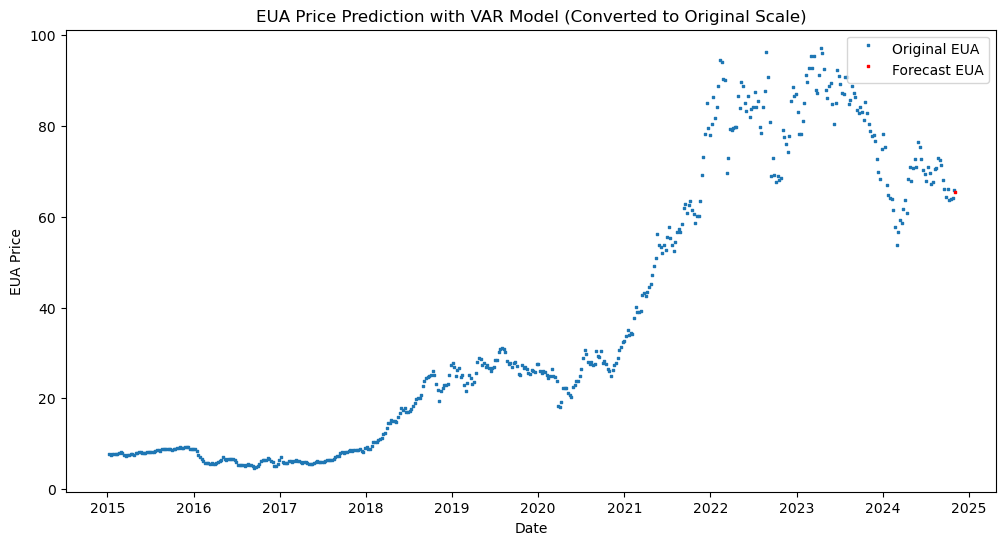

In [9]:
#결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(eua_data['EUA'], label='Original EUA',marker='$·$', linestyle='None')
plt.plot(forecast_original['EUA'], label='Forecast EUA', color='red', marker='$·$', linestyle='None')
plt.legend()
plt.title("EUA Price Prediction with VAR Model (Converted to Original Scale)")
plt.xlabel("Date")
plt.ylabel("EUA Price")